In [1]:
#! python -c 'import qiskit; print(qiskit.__version__);'

In [1]:
import numpy as np
import math
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import Aer,AerSimulator
from qiskit.compiler import transpile
from qiskit.visualization import array_to_latex
from qiskit.circuit.library import Isometry, StatePreparation, Initialize
from qiskit import quantum_info as qi

In [2]:
np.set_printoptions(precision=4)
np.array([1.123456789])

array([1.1235])

$\bullet~$ create a vector with the amplitudes to encode

In [3]:
#vector = np.array([1., 0.])
#vector = np.array([0., 1.])
#vector = np.array([1./np.sqrt(2.), 1./np.sqrt(2.)])
#vector = np.array([1., 1.])

vector = np.array([1, 2, 3, 4])

## number of necessary qubits to encode the vector
nq = int(np.log2(len(vector)))

vector_norm = vector / np.linalg.norm(vector)
print(vector_norm)

[0.1826 0.3651 0.5477 0.7303]


#### Using `Isometry`

In [4]:
vector_circuit = Isometry(vector_norm, num_ancillas_zero=0, num_ancillas_dirty=0)

$\bullet~$ get the circuit

In [5]:
vector_circuit = vector_circuit.definition

$\bullet~$ transpile the circuit

In [6]:
qasm_sim = Aer.get_backend('qasm_simulator')

vector_circuit_t = transpile(vector_circuit, basis_gates=['rz', 'ry', 'sx', 'cx'])

vector_circuit_t.draw()

global phase: 7π/4
      ┌──────────┐ ┌────────────┐┌───┐┌─────────────┐
q_0: ─┤ Rz(-π/2) ├─┤ Ry(1.7506) ├┤ X ├┤ Ry(0.46365) ├
     ┌┴──────────┴┐└────────────┘└─┬─┘└─────────────┘
q_1: ┤ Ry(2.3005) ├────────────────■─────────────────
     └────────────┘

$\bullet~$ do a statevector simulation

In [7]:
sv_sim = Aer.get_backend('statevector_simulator')
job = sv_sim.run(vector_circuit_t)
psi = job.result().get_statevector(vector_circuit_t, decimals=4)
#psi = job.result().get_statevector(vector_circuit_t)
array_to_latex(psi, prefix="| \\psi \\rangle = ")

<IPython.core.display.Latex object>

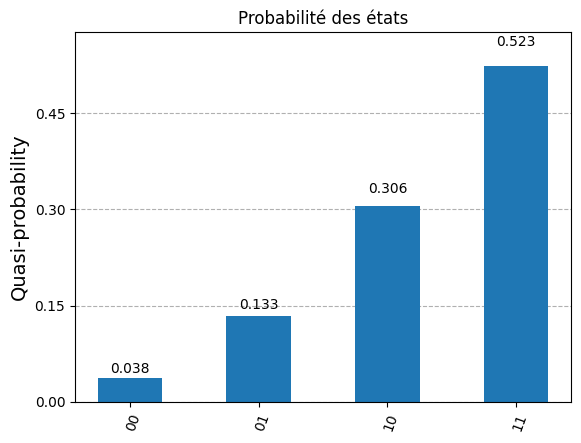

In [8]:

from qiskit.visualization import plot_histogram
vector_circuit = Isometry(vector_norm, num_ancillas_zero=0, num_ancillas_dirty=0)
vector_circuit = vector_circuit.definition
vector_circuit.measure_all()
backend = AerSimulator()
transpiled = transpile(vector_circuit, backend)
job = backend.run(transpiled, shots=2048)
counts = job.result().get_counts()
total_shots = sum(counts.values())
probabilities = {state: count / total_shots for state, count in counts.items()}
plot_histogram(probabilities, title="Probabilité des états")

$\bullet~$ do a circuit unitary simulation

In [9]:
uni_sim = Aer.get_backend('unitary_simulator')
job = uni_sim.run(vector_circuit_t)
unitary = job.result().get_unitary(vector_circuit_t, decimals=4)
#unitary = job.result().get_unitary(vector_circuit_t)
array_to_latex(unitary, prefix="\\text{U} = ")

<IPython.core.display.Latex object>

#### Using `StatePreparation`

In [10]:
qr = QuantumRegister(nq)
cr = ClassicalRegister(nq)
qc = QuantumCircuit(qr, cr)
qc_sp = StatePreparation(vector_norm)
qc.append(qc_sp, qr)
qc.draw()

┌────────────────────────────────────────────────────┐
q3_0: ┤0                                                   ├
      │  State Preparation(0.18257,0.36515,0.54772,0.7303) │
q3_1: ┤1                                                   ├
      └────────────────────────────────────────────────────┘
c0: 2/══════════════════════════════════════════════════════

$\bullet~$ transpile the circuit

In [11]:
#qc_t = transpile(qc, qasm_sim)
#qc_t = transpile(qc, basis_gates=['id', 'rz', 'sx', 'x', 'cx'])
#qc_t = transpile(qc, basis_gates=['id', 'rz', 'ry', 'sx', 'cx'])
qc_t = transpile(qc, basis_gates=['id', 'rz', 'ry', 'ecr', 'x', 'sx'])

qc_t.draw()

global phase: π/2
       ┌──────────┐ ┌────────────┐┌──────┐┌─────────────┐
q3_0: ─┤ Ry(-π/2) ├─┤ Rz(2.9617) ├┤1     ├┤ Ry(0.46365) ├
      ┌┴──────────┴┐└┬──────────┬┘│  Ecr │└────┬───┬────┘
q3_1: ┤ Ry(2.3005) ├─┤ Rz(-π/2) ├─┤0     ├─────┤ X ├─────
      └────────────┘ └──────────┘ └──────┘     └───┘     
c0: 2/═══════════════════════════════════════════════════

$\bullet~$ do a statevector simulation

In [12]:
job = sv_sim.run(qc_t)
psi = job.result().get_statevector(qc_t, decimals=4)
#psi = job.result().get_statevector(vector_circuit_t)
array_to_latex(psi, prefix="| \\psi \\rangle = ")

<IPython.core.display.Latex object>

#### Using `Initialize`

In [13]:
qr = QuantumRegister(nq)
cr = ClassicalRegister(nq)
qc = QuantumCircuit(qr, cr)

In [14]:
psi_0 = qi.Statevector(vector_norm)
init_gate = Initialize(psi_0)
init_gate.label = "init"
qc.append(init_gate, qr)
qc.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(2, 'q6'), 0), Qubit(QuantumRegister(2, 'q6'), 1)), clbits=())

$\bullet~$ transpile the circuit

In [15]:
#qc_t = transpile(qc, qasm_sim)
#qc_t = transpile(qc, basis_gates=['id', 'rz', 'sx', 'x', 'cx'])
#qc_t = transpile(qc, basis_gates=['id', 'rz', 'ry', 'sx', 'cx'])
qc_t = transpile(qc, basis_gates=['id', 'rz', 'ry', 'ecr', 'x', 'sx'])

qc_t.draw()

global phase: π/2
            ┌──────────┐ ┌────────────┐┌──────┐┌─────────────┐ ░ 
q6_0: ─|0>──┤ Ry(-π/2) ├─┤ Rz(2.9617) ├┤1     ├┤ Ry(0.46365) ├─░─
           ┌┴──────────┴┐└┬──────────┬┘│  Ecr │└────┬───┬────┘ ░ 
q6_1: ─|0>─┤ Ry(2.3005) ├─┤ Rz(-π/2) ├─┤0     ├─────┤ X ├──────░─
           └────────────┘ └──────────┘ └──────┘     └───┘      ░ 
c1: 2/═══════════════════════════════════════════════════════════

$\bullet~$ do a statevector simulation

In [16]:
job = sv_sim.run(qc_t)
psi = job.result().get_statevector(qc_t, decimals=4)
#psi = job.result().get_statevector(vector_circuit_t)
array_to_latex(psi, prefix="| \\psi \\rangle = ")

<IPython.core.display.Latex object>

# TEST

In [17]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Charger les données MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

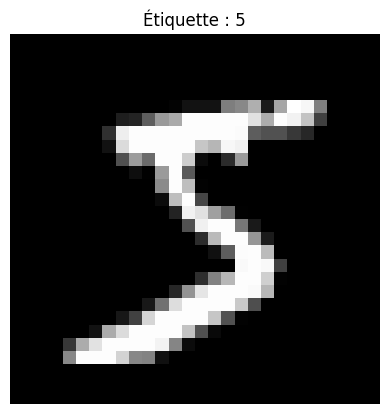

In [18]:
# Sélectionner l'element sur lequel on va travailler
index = 0
image = x_train[index]
label = y_train[index]

# Afficher l'image avec son étiquette
plt.imshow(image, cmap='gray')
plt.title(f"Étiquette : {label}")
plt.axis('off')
plt.show()


In [19]:
#Normalisation
image = image.flatten()
image_norm = image / np.linalg.norm(image)
image_norm

array([0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
      

In [20]:
#Padding
image_norm=np.pad(image_norm, pad_width=(0,1024-len(image_norm)), mode='constant', constant_values=0)

In [21]:
#Verification du padding
len(image_norm)

1024

In [22]:
#Creation du circuit
nq = int(np.log2(len(image_norm))) +40
qr = QuantumRegister(nq)
cr = ClassicalRegister(nq)
qc = QuantumCircuit(qr, cr)

In [23]:
#Encodage du vecteur
psi_0 = qi.Statevector(image_norm)
init_gate = Isometry(image_norm, num_ancillas_zero=20, num_ancillas_dirty=20)
init_gate.label = "init"
qc.append(init_gate, qr)
qc.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=50, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(50, 'q11'), 0), Qubit(QuantumRegister(50, 'q11'), 1), Qubit(QuantumRegister(50, 'q11'), 2), Qubit(QuantumRegister(50, 'q11'), 3), Qubit(QuantumRegister(50, 'q11'), 4), Qubit(QuantumRegister(50, 'q11'), 5), Qubit(QuantumRegister(50, 'q11'), 6), Qubit(QuantumRegister(50, 'q11'), 7), Qubit(QuantumRegister(50, 'q11'), 8), Qubit(QuantumRegister(50, 'q11'), 9), Qubit(QuantumRegister(50, 'q11'), 10), Qubit(QuantumRegister(50, 'q11'), 11), Qubit(QuantumRegister(50, 'q11'), 12), Qubit(QuantumRegister(50, 'q11'), 13), Qubit(QuantumRegister(50, 'q11'), 14), Qubit(QuantumRegister(50, 'q11'), 15), Qubit(QuantumRegister(50, 'q11'), 16), Qubit(QuantumRegister(50, 'q11'), 17), Qubit(QuantumRegister(50, 'q11'), 18), Qubit(QuantumRegister(50, 'q11'), 19), Qubit(QuantumRegister(50, 'q11'), 20), Qubit(QuantumRegister(50, 'q11'), 21), Qubit(QuantumRegister(50, 'q11'), 22), Qubit(Q

In [24]:
#Affichage du nombre de porte standard

qc_t = transpile(qc, basis_gates=['id', 'rz', 'ry', 'ecr', 'x', 'sx'])
qc_t.draw()
print(qc_t.depth())

3710


The depth of the circuit is not good, three time the length of the original data.

# Comprendre la méthode SP + CSP

# implementation SP

### Calcul des angles

$
\theta_{s,p} = 2 \cos^{-1} \left( \sqrt{\frac{\sum_{l=0}^{2^{m-s-1}-1} \left| y_{p*2^{m-s}+l} \right|^2}{\sum_{l=0}^{2^{m-s}-1} \left| y_{p*2^{m-s}+l} \right|^2}} \right)
$


In [25]:
def theta(s, p, vect):

    sum_top = 0.0
    n = int(math.log(len(vect), 2))
    for l in range(2 ** (n - s - 1) - 1 + 1):
        temp = vect[p * 2 ** (n - s) + l]
        sum_top += temp ** 2
    
    sum_bottom = 0.0
    for l in range(2 ** (n - s) - 1 + 1):
        temp = vect[p * 2 ** (n - s) + l]
        sum_bottom += temp ** 2
        
    if sum_bottom == 0:
        return 0.0
    else:
        return 2 * np.arccos(np.sqrt(sum_top) / np.sqrt(sum_bottom))

In [26]:
def theta_array(vect, m):
    
    th = []
    
    for s in range(m):
        for p in range(2 ** s):
            th.append(theta(s, p, vect))
    
    return np.array(th)

In [27]:
vector = np.array([0.1, 0.2, 0.3, 0.4])

m = int(np.log2(len(vector)))

vector_norm = vector / np.linalg.norm(vector)

th = theta_array(vector_norm, m)
print(m)
print(th)

2
[2.3005 2.2143 1.8546]


In [28]:
np.log2(1024)

np.float64(10.0)

In [29]:
def rotation_ry(theta, m, A):
    M = 2 ** m - 1 
    
    qc = QuantumCircuit(A)

    for i in range(M):
        qc.ry(theta[i], A[i])

    return qc

In [30]:
# Exemple d'utilisation
M = 2 ** m - 1
A = QuantumRegister(M, 'A')

# Création du circuit principal
qc = rotation_ry(th, m, A)

qc.draw()

┌────────────┐
A_0: ┤ Ry(2.3005) ├
     ├────────────┤
A_1: ┤ Ry(2.2143) ├
     ├────────────┤
A_2: ┤ Ry(1.8546) ├
     └────────────┘

In [31]:
def rotation_ry_parallel(theta, m, A, B):
    M = 2 ** m - 1 
    
    qc = QuantumCircuit(A, B)

    for i in range(M):
        qc.cry(-theta[i], B[i], A[i])

    return qc

m = 2
M = 2 ** m - 1 
A = QuantumRegister(M, 'A')
B = QuantumRegister(M, 'B')

qc = rotation_ry_parallel(th, m, A, B)

print(qc.draw())

     ┌─────────────┐                              
A_0: ┤ Ry(-2.3005) ├──────────────────────────────
     └──────┬──────┘┌─────────────┐               
A_1: ───────┼───────┤ Ry(-2.2143) ├───────────────
            │       └──────┬──────┘┌─────────────┐
A_2: ───────┼──────────────┼───────┤ Ry(-1.8546) ├
            │              │       └──────┬──────┘
B_0: ───────■──────────────┼──────────────┼───────
                           │              │       
B_1: ──────────────────────■──────────────┼───────
                                          │       
B_2: ─────────────────────────────────────■───────
                                                  


# Implementation de SPF

In [32]:
def cnot(R, m):
    qc = QuantumCircuit(R)
    num_qubits = R.size
    
    for j in range(num_qubits):
        qc.x(R[j])
    
    return qc

t = 2
m = 2**(t+1)

qd = QuantumRegister(m, 'D')

sub_circuit = cnot(qd, t)

sub_circuit.draw()

┌───┐
D_0: ┤ X ├
     ├───┤
D_1: ┤ X ├
     ├───┤
D_2: ┤ X ├
     ├───┤
D_3: ┤ X ├
     ├───┤
D_4: ┤ X ├
     ├───┤
D_5: ┤ X ├
     ├───┤
D_6: ┤ X ├
     ├───┤
D_7: ┤ X ├
     └───┘

In [33]:
def cnot_parallel(R, t):
    sub_circuit = QuantumCircuit(R)
    num_qubits = R.size
    power = 2 ** t
    
    for j in range(power):
        control_idx = j
        target_idx = control_idx + power
        sub_circuit.cx(R[control_idx], R[target_idx])
    
    return sub_circuit

t = 2
m = 2**(t+1)

qd = QuantumRegister(m, 'D')

sub_circuit = cnot_parallel(qd, t)

sub_circuit.draw()


D_0: ──■─────────────────
       │                 
D_1: ──┼────■────────────
       │    │            
D_2: ──┼────┼────■───────
       │    │    │       
D_3: ──┼────┼────┼────■──
     ┌─┴─┐  │    │    │  
D_4: ┤ X ├──┼────┼────┼──
     └───┘┌─┴─┐  │    │  
D_5: ─────┤ X ├──┼────┼──
          └───┘┌─┴─┐  │  
D_6: ──────────┤ X ├──┼──
               └───┘┌─┴─┐
D_7: ───────────────┤ X ├
                    └───┘

In [34]:
def copy(R, i):
    global_circuit = QuantumCircuit(R)
    
    for j in range(i):
        sub_circuit = cnot_parallel(R, j)
        global_circuit.compose(sub_circuit, inplace=True)

    return global_circuit


i = 3
m = 2**i

qd = QuantumRegister(m, 'D')
qc = copy(qd, i)

qc.draw()


D_0: ──■────■─────────■─────────────────
     ┌─┴─┐  │         │                 
D_1: ┤ X ├──┼────■────┼────■────────────
     └───┘┌─┴─┐  │    │    │            
D_2: ─────┤ X ├──┼────┼────┼────■───────
          └───┘┌─┴─┐  │    │    │       
D_3: ──────────┤ X ├──┼────┼────┼────■──
               └───┘┌─┴─┐  │    │    │  
D_4: ───────────────┤ X ├──┼────┼────┼──
                    └───┘┌─┴─┐  │    │  
D_5: ────────────────────┤ X ├──┼────┼──
                         └───┘┌─┴─┐  │  
D_6: ─────────────────────────┤ X ├──┼──
                              └───┘┌─┴─┐
D_7: ──────────────────────────────┤ X ├
                                   └───┘

In [35]:
def cswap_parallel(R, S, t):
    sub_circuit = QuantumCircuit(R,S)
    R_qubits = R.size
    S_qubits = S.size
    
    num_cswaps = 2 ** t

    for i in range(num_cswaps):
        control = R[i]
        target1 = S[i]
        target2 = S[i + num_cswaps]
        sub_circuit.cswap(control, target1, target2)
    return sub_circuit

m = 2
num_qubits_R = 2**m
num_qubits_S = 2**(m+1)


R = QuantumRegister(num_qubits_R, name='R')
S = QuantumRegister(num_qubits_S, name='S')

qc = cswap_parallel(R, S, m)
qc.draw()

qc_adj =qc
qc_adj.draw()


R_0: ─■──────────
      │          
R_1: ─┼──■───────
      │  │       
R_2: ─┼──┼──■────
      │  │  │    
R_3: ─┼──┼──┼──■─
      │  │  │  │ 
S_0: ─X──┼──┼──┼─
      │  │  │  │ 
S_1: ─┼──X──┼──┼─
      │  │  │  │ 
S_2: ─┼──┼──X──┼─
      │  │  │  │ 
S_3: ─┼──┼──┼──X─
      │  │  │  │ 
S_4: ─X──┼──┼──┼─
         │  │  │ 
S_5: ────X──┼──┼─
            │  │ 
S_6: ───────X──┼─
               │ 
S_7: ──────────X─

In [36]:
def CopySwapSubroutine(R, S, m):
    circuit = QuantumCircuit(*R, S)
    
    for i in range(m):
        for j in range(m-i-1):
            cnot_sub_circuit = cnot_parallel(R[j], i)
            circuit.compose(cnot_sub_circuit,qubits=R[j], inplace=True)
        cswap_sub_circuit = cswap_parallel(R[m-i-1], S, i)
        circuit.compose(cswap_sub_circuit,qubits=[*R[m-i-1],*S], inplace=True)
        circuit.barrier()
    
    return circuit

m = 4

# Création de registres R avec noms uniques
R = []
for i in range(m):
    R_size = 2 ** (i)
    R.append(QuantumRegister(R_size, f'R_{i}'))  # Noms uniques
R = list(reversed(R))

S = QuantumRegister(2 ** m, 'S')

qc = CopySwapSubroutine(R, S, m)

print(qc.draw())


             ░            ░                      ░                          ░ 
R_3_0: ──■───░───■────────░───■──────────────────░──■───────────────────────░─
       ┌─┴─┐ ░   │        ░   │                  ░  │                       ░ 
R_3_1: ┤ X ├─░───┼────■───░───┼────■─────────────░──┼──■────────────────────░─
       └───┘ ░ ┌─┴─┐  │   ░   │    │             ░  │  │                    ░ 
R_3_2: ──────░─┤ X ├──┼───░───┼────┼────■────────░──┼──┼──■─────────────────░─
             ░ └───┘┌─┴─┐ ░   │    │    │        ░  │  │  │                 ░ 
R_3_3: ──────░──────┤ X ├─░───┼────┼────┼────■───░──┼──┼──┼──■──────────────░─
             ░      └───┘ ░ ┌─┴─┐  │    │    │   ░  │  │  │  │              ░ 
R_3_4: ──────░────────────░─┤ X ├──┼────┼────┼───░──┼──┼──┼──┼──■───────────░─
             ░            ░ └───┘┌─┴─┐  │    │   ░  │  │  │  │  │           ░ 
R_3_5: ──────░────────────░──────┤ X ├──┼────┼───░──┼──┼──┼──┼──┼──■────────░─
             ░            ░      └───┘┌─┴─┐  │   ░  

Declaration du flag

In [45]:
def FLAG_Subroutine(D, F, m):
    
    circuit = QuantumCircuit(*D, *F)

    for j in range(m):
        circuit.x(F[j][0])
    circuit.barrier()
    
    for i in range(m - 1):
        copy_circuit = copy(D[i], m-2-i)
        circuit.compose(copy_circuit, qubits=D[i], inplace=True)
    circuit.barrier()
    
    for i in range(m - 1):
        for q in range(m - 1- i):
            cswap_circuit = cswap_parallel(D[q], F[q+1+i], i)
            circuit.compose(cswap_circuit, qubits=[*D[q], *F[q+1+i]], inplace=True)
    circuit.barrier()
        
    for i in range(m - 1):
        copy_circuit_inverse = copy(D[i], m-2-i).inverse()
        circuit.compose(copy_circuit_inverse, qubits=D[i], inplace=True)

    return circuit

# Paramètre m
m = 3

# Création des registres D et F
D = [QuantumRegister(max(1, 2**(m-j-2)), name=f'D{j}') for j in range(m)]
F = [QuantumRegister(2**j, name=f'F{j}') for j in range(m)]
# Création du circuit FLAG
qc_FLAG = FLAG_Subroutine(D, F, m)

print(qc_FLAG.draw())  # Affichage du circuit


            ░       ░              ░      
D0_0: ──────░───■───░──■─────■─────░───■──
            ░ ┌─┴─┐ ░  │     │     ░ ┌─┴─┐
D0_1: ──────░─┤ X ├─░──┼─────┼──■──░─┤ X ├
            ░ └───┘ ░  │     │  │  ░ └───┘
  D1: ──────░───────░──┼──■──┼──┼──░──────
            ░       ░  │  │  │  │  ░      
  D2: ──────░───────░──┼──┼──┼──┼──░──────
      ┌───┐ ░       ░  │  │  │  │  ░      
  F0: ┤ X ├─░───────░──┼──┼──┼──┼──░──────
      ├───┤ ░       ░  │  │  │  │  ░      
F1_0: ┤ X ├─░───────░──X──┼──┼──┼──░──────
      └───┘ ░       ░  │  │  │  │  ░      
F1_1: ──────░───────░──X──┼──┼──┼──░──────
      ┌───┐ ░       ░     │  │  │  ░      
F2_0: ┤ X ├─░───────░─────X──X──┼──░──────
      └───┘ ░       ░     │  │  │  ░      
F2_1: ──────░───────░─────X──┼──X──░──────
            ░       ░        │  │  ░      
F2_2: ──────░───────░────────X──┼──░──────
            ░       ░           │  ░      
F2_3: ──────░───────░───────────X──░──────
            ░       ░              ░      


In [38]:
from qiskit import QuantumCircuit, QuantumRegister

def SPF(D, A, m):
    circuit = QuantumCircuit(*D, *A)

    for i in range(m):
        for q in range(i - 1):
            if (i - q) % 2 == 1 and 3 * (i - q - 1) // 2 - 1 <= m - q - 3:
                cnot_circuit = cnot_parallel(D[q], 3 * (i - q - 1) // 2 - 1)
                circuit.compose(cnot_circuit, qubits=D[q], inplace=True)
            elif (i - q) % 2 == 0 and 3 * (i - q) // 2 - 2 <= m - q - 2:
                cswap_circuit = cswap_parallel(D[q], A[i - 1 + (i - q) // 2], 3 * (i - q) // 2 - 2)
                circuit.compose(cswap_circuit, qubits=[*D[q], *A[i - 1 + (i - q) // 2]], inplace=True)

        for q in range(i):
            if (i - q) % 2 == 1 and 3 * (i - q - 1) // 2 <= m - q - 2:
                cswap_circuit = cswap_parallel(D[q], A[i + (i - q - 1) // 2], 3 * (i - q - 1) // 2)
                circuit.compose(cswap_circuit, qubits=[*D[q], *A[i + (i - q - 1) // 2]], inplace=True)
            elif (i - q) % 2 == 0 and 3 * (i - q) // 2 - 2 <= m - q - 3:
                cnot_circuit = cnot_parallel(D[q], 3 * (i - q) // 2 - 2)
                circuit.compose(cnot_circuit, qubits=D[q], inplace=True)

        for q in range(i + 1):
            if i == q:
                circuit.swap(D[q][0], A[i][0])
            elif (i - q) % 2 == 1 and 3 * (i - q - 1) // 2 <= m - q - 3:
                cnot_circuit = cnot_parallel(D[q], 3 * (i - q - 1) // 2)
                circuit.compose(cnot_circuit, qubits=D[q], inplace=True)
            elif (i - q) % 2 == 0 and 3 * (i - q) // 2 - 1 <= m - q - 2:
                cswap_circuit = cswap_parallel(D[q], A[i + (i - q) // 2], 3 * (i - q) // 2 - 1)
                circuit.compose(cswap_circuit, qubits=[*D[q], *A[i + (i - q) // 2]], inplace=True)

    for i in reversed(range(1, m)):
        for q in range(i + 1):
            if i == q:
                continue
            elif (i - q) % 2 == 1 and 3 * (i - q - 1) // 2 <= m - q - 3:
                cnot_circuit = cnot_parallel(D[q], 3 * (i - q - 1) // 2)
                circuit.compose(cnot_circuit, qubits=D[q], inplace=True)
            elif (i - q) % 2 == 0 and 3 * (i - q) // 2 <= m - q - 2:
                cswap_circuit = cswap_parallel(D[q], A[i + (i - q) // 2], 3 * (i - q) // 2)
                circuit.compose(cswap_circuit, qubits=[*D[q], *A[i + (i - q) // 2]], inplace=True)

        for q in range(i):
            if (i - q) % 2 == 1 and 3 * (i - q - 1) // 2 <= m - q - 2:
                cswap_circuit = cswap_parallel(D[q], A[i + (i - q - 1) // 2], 3 * (i - q - 1) // 2)
                circuit.compose(cswap_circuit, qubits=[*D[q], *A[i + (i - q - 1) // 2]], inplace=True)
            elif (i - q) % 2 == 0 and 3 * (i - q) // 2 - 2 <= m - q - 3:
                cnot_circuit = cnot_parallel(D[q], 3 * (i - q) // 2 - 2)
                circuit.compose(cnot_circuit, qubits=D[q], inplace=True)

        for q in range(i - 1):
            if (i - q) % 2 == 1 and 3 * (i - q - 1) // 2 - 1 <= m - q - 3:
                cnot_circuit = cnot_parallel(D[q], 3 * (i - q - 1) // 2 - 1)
                circuit.compose(cnot_circuit, qubits=D[q], inplace=True)
            elif (i - q) % 2 == 0 and 3 * (i - q) // 2 - 2 <= m - q - 2:
                cswap_circuit = cswap_parallel(D[q], A[i - 1 + (i - q) // 2], 3 * (i - q) // 2 - 2)
                circuit.compose(cswap_circuit, qubits=[*D[q], *A[i - 1 + (i - q) // 2]], inplace=True)

    return circuit


m = 2
D = [QuantumRegister(m, name=f'D{j}') for j in range(m)]
A = [QuantumRegister(2**j, name=f'A{j}') for j in range(m)]

# Création du circuit SPF
qc_SPF = SPF(D, A, m)
print(qc_SPF.draw())


                  
D0_0: ─X──■─────■─
       │  │     │ 
D0_1: ─┼──┼─────┼─
       │  │     │ 
D1_0: ─┼──┼──X──┼─
       │  │  │  │ 
D1_1: ─┼──┼──┼──┼─
       │  │  │  │ 
  A0: ─X──┼──┼──┼─
          │  │  │ 
A1_0: ────X──X──X─
          │     │ 
A1_1: ────X─────X─
                  


In [39]:
from qiskit import QuantumCircuit, QuantumRegister

def SP_Circuit(m, theta, measure = False):
    M = 2 ** m - 1  # Nombre total de rotations et d'ancillas
    
    # Définition des registres
    Q = QuantumRegister(m, 'Q')
    A = QuantumRegister(M, 'A')
    F = QuantumRegister(M, 'F')
    C = ClassicalRegister(m, 'C') 
    qc = QuantumCircuit(Q, A, F, C)

    # Étape 1 : Appliquer les rotations contrôlées
    rotation_circuit = rotation_ry(theta, m, A)
    qc.compose(rotation_circuit, qubits=A[:], inplace=True)
    qc.barrier(label="Rotations Ry")

    # Etape 2 : Appliquer le bloc SPF
    #spf_circuit = SPF(D=[A], A=[F], m=M)
    qc.compose(qc_SPF, qubits=[Q[0],F[0],Q[1],F[1]]+A[:], inplace=True)
    qc.barrier(label="SPF")

    # Etape 3 : Appliquer FLAG
    cnot_circuit = cnot(F, m)
    qc.compose(cnot_circuit, qubits=F[:], inplace=True)
    #flag_circuit = FLAG_Subroutine(D=[A], F=[F], m=M)
    qc.compose(qc_FLAG, qubits=Q[:]+F[:], inplace=True)
    qc.barrier(label="FLAG")

    # Etape 4 : Appliquer les rotations inverses
    inverse_rotation_circuit = rotation_ry_parallel(theta, m, A, F)
    qc.compose(inverse_rotation_circuit, qubits=A[:] + F[:], inplace=True)
    qc.barrier(label="Inverse Ry")

    # Etape 5 : Appliquer FLAG inverse
    qc.compose(qc_FLAG.inverse(), qubits=Q[:]+F[:], inplace=True)
    cnot_circuit = cnot(F, m)
    qc.compose(cnot_circuit, qubits=F[:], inplace=True)
    qc.barrier(label="FLAG†")

    # Etape 6 : Test
    qc.save_statevector()
    if measure:
        qc.measure(Q, C)

    return qc


m = 2

qc_sp = SP_Circuit(m, th)
print(qc_sp.draw(fold=152))

                    Rotations Ry              SPF            ░  ░     ░  FLAG                                               Inverse Ry  ░     ░  ░ »
Q_0: ────────────────────░────────X──■─────■───░─────────────░──░──■──░───░─────────────────────────────────────────────────────░───────░──■──░──░─»
                         ░        │  │     │   ░             ░  ░  │  ░   ░                                                     ░       ░  │  ░  ░ »
Q_1: ────────────────────░────────┼──┼──X──┼───░─────────────░──░──┼──░───░─────────────────────────────────────────────────────░───────░──┼──░──░─»
     ┌────────────┐      ░        │  │  │  │   ░             ░  ░  │  ░   ░   ┌─────────────┐                                   ░       ░  │  ░  ░ »
A_0: ┤ Ry(2.3005) ├──────░────────X──┼──┼──┼───░───────────────────┼──────░───┤ Ry(-2.3005) ├───────────────────────────────────░──────────┼───────»
     ├────────────┤      ░           │  │  │   ░                   │      ░   └──────┬──────┘┌────────────

In [40]:
"""
def loadf(qc, A, B, D, F):
    subroutine(qc, A, B, D, F)
    
    for i in range(N - M):
        rotation_ry_parallel(theta, m, A, B)

    subroutine(qc, A, B, D, F).inverse()

def subroutine(qc, D, B, F):
    
    B_size = B.size
    m=0 #temporaire 
    cnot(A, m)

    for i in range(m) do
        copy(D, B_size+1).inverse()

    CopySwapSubroutine(D, A, m)

    for i in range(B_size):
        CopySwapSubroutine(D, B, n-m)
    
    for i in range(M):
        copy(A, B_size)
    
    for i in range(B_size):
         copy(F, M)
"""

'\ndef loadf(qc, A, B, D, F):\n    subroutine(qc, A, B, D, F)\n    \n    for i in range(N - M):\n        rotation_ry_parallel(theta, m, A, B)\n\n    subroutine(qc, A, B, D, F).inverse()\n\ndef subroutine(qc, D, B, F):\n    \n    B_size = B.size\n    m=0 #temporaire \n    cnot(A, m)\n\n    for i in range(m) do\n        copy(D, B_size+1).inverse()\n\n    CopySwapSubroutine(D, A, m)\n\n    for i in range(B_size):\n        CopySwapSubroutine(D, B, n-m)\n    \n    for i in range(M):\n        copy(A, B_size)\n    \n    for i in range(B_size):\n         copy(F, M)\n'

# TEST IRIS

In [41]:
from sklearn.datasets import load_iris
import pandas as pd

iris = load_iris()

#Afficher head
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.target
df['target_name'] = df['target'].map(dict(enumerate(iris.target_names)))
print(df.head())

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target target_name  
0       0      setosa  
1       0      setosa  
2       0      setosa  
3       0      setosa  
4       0      setosa  


In [42]:
sample = iris.data[42] #on prend un sample
print("sample =",sample)

m = int(np.log2(len(sample)))

sample_norm = sample / np.linalg.norm(sample)

th = theta_array(sample_norm, m)
print("m =",m)
print("sample normalisé =",sample_norm)
print("theta =",th)

# Construction et affichage du circuit
qc_sp = SP_Circuit(m, th, True)

sample = [4.4 3.2 1.3 0.2]
m = 2
sample normalisé = [0.7861 0.5717 0.2323 0.0357]
theta = [0.4744 1.2576 0.3053]



Total counts are: {'10': 630, '00': 1267, '01': 99, '11': 4}


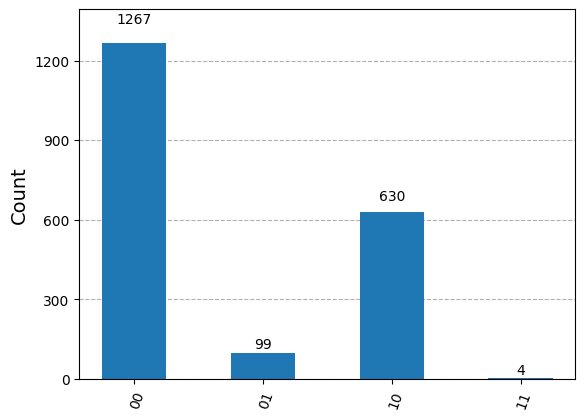

In [43]:
from qiskit.visualization import plot_histogram

simulator = Aer.get_backend('qasm_simulator')
job = simulator.run(qc_sp, shots=2000)
result = job.result()
counts = result.get_counts(qc_sp)
print("\nTotal counts are:", counts)

plot_histogram(counts)

In [44]:
statevector = job.result().get_statevector(qc_sp, decimals=4)
statevector = np.round(statevector, 4)

print("sample normalisé =",sample_norm)
print("statevector =",statevector[:4])
print(sum(statevector[:4]*statevector[:4]))
qc_sp = SP_Circuit(m, th)
print("profondeur =",qc_sp.depth())

sample normalisé = [0.7861 0.5717 0.2323 0.0357]
statevector = [0.7861+0.j 0.2323+0.j 0.5717+0.j 0.0357+0.j]
(1.0000318799999999+0j)
profondeur = 12
